In [1]:
# # !pip freeze > /home/jovyan/proj/docker/jupyter-base-ds/requirements.txt
# !pip freeze | grep -v 'mennowitteveen' > ~/proj/docker/jupyter-base-ds/requirements.txt
# !git config --global user.email "" 
# !git config --global user.name  "Menno Witteveen"
# !git -C /home/jovyan/proj/docker/jupyter-base-ds/ add requirements.txt
# !git -C /home/jovyan/proj/docker/jupyter-base-ds/ status
# !git -C /home/jovyan/proj/docker/jupyter-base-ds/ commit -m "update req.txt"


In [2]:
# cd ~/proj/docker/jupyter-base-ds
# docker build --rm -t mennowitteveen/my-datascience-notebook-1 .

In [3]:
# !pwd

# Imports

In [1]:
%config Completer.use_jedi = False
########################################################
## Base Imports:

# Sys Imports:
import time, sys, os

# Standard Imports:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, linalg

#########################################################
## Experiment Specific Imports

# Logistics Imports:
import inspect, glob, re #pyreadr # getsource()
import pickle, submitit, functools
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from mjwt.tools import jobinfo, corr, implot, sizegb, psrc, beep, Timer, Struct as mStruct

# ML Imports:
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, ParameterGrid
from scipy.stats import pearsonr, spearmanr

# Genomics Imports:
import pysnptools as pst
from pysnptools.snpreader import Bed, Pheno, SnpHdf5, SnpData
from pysnptools.pstreader import PstData, PstHdf5, PstReader
from lambdapred.utils import load_bimfam

########################################################
## Configuration & Initialisation

# Display Configuration:
from IPython.display import set_matplotlib_formats, display #, HTML, Audio, Javascript
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('max_colwidth', 200) 
# pd.set_option('display.max_colwidth', None) # No pd trunkation (radical)
# display(HTML("<style>.container { width:75% !important; }</style>"))
# pd.reset_option('all')

# Initializations & Extensions:
timer = Timer(); toc = timer.toc; tic = timer.tic; tic('')
notebook = False  if '__file__' in locals() else True
get_ipython().run_line_magic('load_ext', 'line_profiler')
log=np.log10

# Preprocessing

In [2]:
# https://dougspeed.com/snp-subsets/ 
# https://www.dropbox.com/s/xabjdu6squ6u56r/hapmap3.snps

In [5]:
# Preprocess hm3 snp rsid list:
df = pd.read_csv('~/proj/data/defs/orig/hapmap3.snps', header=None, delim_whitespace=True)
df.columns = ['snp','varinfo','A1','A2']
assert (df['snp'].str[:2] == 'rs').mean() == 1.0 # Only rsids
df[['chrom','pos']] = df['varinfo'].str.split(':', expand=True)
df['cm'] = 0; df = df.astype({'pos':int, 'chrom': int})
hm3_df = df[['chrom', 'snp', 'cm', 'pos', 'A1', 'A2']]; del df
hm3_fn = '~/proj/data/defs/hm3.bim'
hm3_df.to_csv(hm3_fn, sep='\t', index=False, header=False)
bim, fam = load_bimfam(hm3_fn, fam=False); bim
assert (bim == hm3_df).all().all(); del bim, fam
hm3_df['cm'] = np.nan; hm3_sid = hm3_df['snp'].values
hm3_df = hm3_df.set_index('snp', drop=False)

In [15]:
ls ~/proj/repos/1000-genomes-genetic-maps/interpolated_OMNI/ | head -3

chr10.OMNI.interpolated_genetic_map
chr11.OMNI.interpolated_genetic_map
chr12.OMNI.interpolated_genetic_map


In [12]:
# Fill the Centimorgan column based on the rsID:
fmtfn = '/home/jovyan/proj/repos/1000-genomes-genetic-maps/interpolated_OMNI/chr*.OMNI.interpolated_genetic_map'
# OMNI was chosen as default cause it is a CEU cM reference (default bigsnpr)
lst = []
for fn in tqdm(glob.glob(fmtfn)):
    df = pd.read_csv(fn, header=None, delim_whitespace=True).set_axis(['snp','pos','cm'], 1)
    new_df = df[df['snp'].isin(hm3_sid)]; del df
    hm3_df.loc[new_df['snp'], 'cm'] = new_df['cm'].values
assert hm3_df['cm'].isna().sum() == 0

# Contin

In [16]:
!ls -lah ~/proj/data/defs/

total 33M
drwxr-xr-x  6 jovyan users  192 Feb 15 16:25 .
drwxr-xr-x 12 jovyan users  384 Feb 15 14:00 ..
-rw-r--r--  1 jovyan users 6.1K Feb 15 16:31 .DS_Store
-rw-r--r--  1 jovyan users  32M Feb 21 14:11 hm3.bim
drwxr-xr-x  3 jovyan users   96 Feb 14 12:20 orig
drwxr-xr-x  8 jovyan users  256 Oct 13  2021 regdef


In [18]:
def fun(arg):
    return arg.iloc[:3000]
# df.groupby('chrom', as_index=False, group_keys=False).apply(fun)
sel_df = hm3_df[hm3_df.chrom.isin((21,22))]
# df = df.sample(2000, random_state=42).sort_index()
sel_df = sel_df.groupby('chrom', group_keys=False).apply(fun); sel_df

,chrom,snp,cm,pos,A1,A2
snp,,,,,,
rs469863,21,rs469863,0.000000,10992232,G,A
rs3965725,21,rs3965725,0.000000,14597009,C,A
rs2775537,21,rs2775537,0.000000,14601415,A,G
rs2261645,21,rs2261645,0.000000,14630588,A,G
rs2742158,21,rs2742158,0.000000,14638916,T,C
...,...,...,...,...,...,...
rs2330555,22,rs2330555,10.752404,24013288,G,A
rs12157657,22,rs12157657,10.752412,24014229,T,C
rs1109403,22,rs1109403,10.752429,24016138,A,G


In [19]:
!wc -l /home/jovyan/proj/data/g1000/*.bim

22665064 /home/jovyan/proj/data/g1000/g1000_eur.bim


In [20]:
mini_dn = '~/proj/data/mini/'
!mkdir {mini_dn}
minisnps_fn = mini_dn+'rsid-list.txt'
sel_df['snp'].to_csv(minisnps_fn, header=False,index=False)
!head -5 {minisnps_fn}

mkdir: cannot create directory ‘/home/jovyan/proj/data/mini/’: File exists
rs469863
rs3965725
rs2775537
rs2261645
rs2742158


In [60]:
g1k_fn  = '~/proj/data/g1000/g1000_eur'
mini_fn = mini_dn + 'mini'
!plink --bfile {g1k_fn} --extract {minisnps_fn} --maf 0.1 --make-bed --out {mini_fn}

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jovyan/proj/data/mini/mini.log.
Options in effect:
  --bfile /home/jovyan/proj/data/g1000/g1000_eur
  --extract /home/jovyan/proj/data/mini/rsid-list.txt
  --maf 0.1
  --make-bed
  --out /home/jovyan/proj/data/mini/mini

3934 MB RAM detected; reserving 1967 MB for main workspace.
22665064 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
--extract: 6000 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is in [0.9999995, 1).
1302 variants removed du

In [61]:
!head -3 {mini_fn+'.bim'}
print('----------------')
!tail -3 {mini_fn+'.bim'}

21	rs3965725	0	14597009	C	A
21	rs2775537	0	14601415	A	G
21	rs2261645	0	14630588	A	G
----------------
22	rs1109403	0	24016138	A	G
22	rs10427834	0	24020575	C	T
22	rs5751708	0	24022307	G	A


In [62]:
# Load bim dataframe and merge cM into it:
bim_df, _ = load_bimfam(mini_fn)
bim_df = bim_df.set_index('snp', drop=False)
bim_df['cm'] = np.nan
bim_df['cm'] = hm3_df.loc[bim_df['snp'],'cm']
assert bim_df.cm.isna().sum() == 0

# Save new bim file:
fn = mini_fn+'.bim'
!mv {fn} {fn+'.orig'}
bim_df.to_csv(fn, sep='\t', header=None, index=False)

In [63]:
!head -3 {mini_fn+'.bim'}
print('----------------')
!tail -3 {mini_fn+'.bim'}

21	rs3965725	0.0	14597009	C	A
21	rs2775537	0.0	14601415	A	G
21	rs2261645	0.0	14630588	A	G
----------------
22	rs1109403	10.752428835999998	24016138	A	G
22	rs10427834	10.7524668702	24020575	C	T
22	rs5751708	10.7524817169	24022307	G	A


# Sims

## Data Loading and prelim tests:

In [9]:
# psrc(load_bimfam)

/home/jovyan/proj/repos/pgsbenchmark/pgsbenchmark/loaders.py:122: UserWarning: No 'beta_mrg' column detected in sst_df! This means that no summary stats were detected.
  warnings.warn('No \'beta_mrg\' column detected in sst_df! This means that no summary stats were detected.')


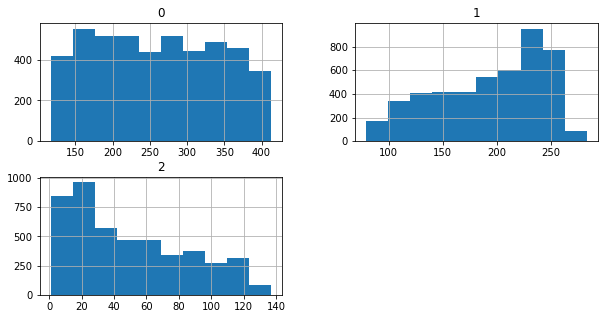

In [64]:
%run -i ~/proj/repos/pgsbenchmark/pgsbenchmark/loaders.py

# very naughty improper python line to correct filenames (insert full path in place of '~'):
locals().update({varname: os.path.expanduser(var) for varname, var in locals().items() if (type(var) is str) and (varname[-3:] == '_fn')})
srd = Bed(mini_fn, count_A1=True); sda = srd.read()
regdef_df = pd.read_csv('~/proj/data/defs/regdef/regions_1blk_shift=0.regdef.tsv', delimiter='\t') 
bim_df, fam_df = load_bimfam(mini_fn)
link = LinkageData(sst_df=bim_df, regdef_df=regdef_df, srd=srd)
pd.DataFrame.from_dict({cnt: np.sum(sda.val == cnt, axis=0) for cnt in [0,1,2]}).hist()

# Standardize things:
sda, stansda = sda.standardize(return_trained=True) #, standardizer=stansdainit)
sim_sda = sda

## Simulate Genetic Effects & Phenotypes

In [65]:
random_state = 42
h2 = 0.4 # Proportion of variance explained by genetics
y_var = 1.0
p_causal = 0.02 # probability of being 'causal'
n_snps = len(sim_sda.sid)
n_samps = len(sim_sda.iid)
scaleffects_df = pd.DataFrame(index=pd.Index(sim_sda.sid,name='snp'))
index = pd.MultiIndex.from_arrays(sim_sda.iid.copy().T, names=['FID','IID'])
pheno_df   = pd.DataFrame(index=index)
X = sim_sda.val

# Laplace
# spike slab
# ridge
# fut: PRS-CS

In [66]:
## Spike & Slab:
np.random.seed(random_state+7)
n_causal = int(np.ceil(p_causal*n_snps))
rand_sel = np.random.permutation(n_snps)[:n_causal]
w           = np.zeros(n_snps)
w[rand_sel] = np.random.randn(n_causal)*np.sqrt(h2/n_causal)
scaleffects_df['spike_slab'] = w
Xw = X.dot(w)
e  = np.random.randn(n_samps)*np.sqrt(1-h2)
y  = Xw + e
pheno_df['spike_slab'] = y

print(Xw.var()) # should be equal to h2, if y_var = 1.0
print(y.std())

0.412432983074941
0.9842875981708776


In [67]:
## Laplace:
np.random.seed(random_state+8)
w = np.random.laplace(0,1,n_snps)*np.sqrt(0.5*h2/n_snps)
scaleffects_df['laplace'] = w
Xw = X.dot(w)
e  = np.random.randn(n_samps)*np.sqrt(1-h2)
y  = Xw + e
pheno_df['laplace'] = y
print(Xw.var()) # should be equal to h2, if y_var = 1.0
print(y.std())

0.3752758106701261
1.0210696274295905


In [68]:
## Ridge:
np.random.seed(random_state+9)
w = np.random.randn(n_snps)*np.sqrt(h2/n_snps)
scaleffects_df['ridge'] = w
Xw = X.dot(w)
e  = np.random.randn(n_samps)*np.sqrt(1-h2)
y  = Xw + e
pheno_df['ridge'] = y
print(Xw.var()) # should be equal to h2, if y_var = 1.0
print(y.std())

0.37773541974878716
1.0013016597016546


In [69]:
# oldeffects_df = effects_df.copy()
effects_df = scaleffects_df/stansda.stats[:,[1]]

# Store effects & phenotypes:
effects_df.to_csv('effects_df.csv')
pheno_df.to_csv('pheno_df.csv')
df = pd.read_csv('pheno_df.csv').set_index(['FID','IID']); display(df.head())
df = pd.read_csv('effects_df.csv').set_index(['snp']); display(df.head())

,,spike_slab,laplace,ridge
FID,IID,,,
HG00096,HG00096,0.691116,0.277061,-1.373948
HG00097,HG00097,-1.235755,0.716184,0.374566
HG00099,HG00099,-0.457048,-0.059474,0.111392
HG00100,HG00100,-0.195454,0.919349,-1.044286
HG00101,HG00101,0.482814,0.723345,0.527562


,spike_slab,laplace,ridge
snp,,,
rs3965725,0.0,-0.000104,-0.003937
rs2775537,0.0,-0.007287,0.001472
rs2261645,0.0,-0.006313,0.016632
rs2742158,0.0,-0.002188,-0.018126
rs2260810,0.0,-0.002647,0.001329


## Tests 4 Allele Scaling of Effects

In [77]:
Y = X@scaleffects_df
df = corr(pheno_df,Y); display(df)
print(df.iloc[-1,-1])
print(pearsonr(Xw, y)[0])
print(pearsonr(Y['ridge'],Xw))

int_sda = srd.read() #dtype='int8', _require_float32_64=False)
mod_df = scaleffects_df/stansda.stats[:,[1]]
Ys = int_sda.val@mod_df
display(corr(Y,Ys))

for col in Y.columns:
    print(pearsonr(Y[col],Ys[col])) # <- perfect correlation!

,spike_slab,laplace,ridge
spike_slab,0.619836,0.072870,0.080358
laplace,0.119467,0.633979,0.068332
ridge,0.074576,0.023014,0.642320


0.6423195870754093
0.6423195870754088
(1.0, 0.0)


,spike_slab,laplace,ridge
spike_slab,1.000000,0.164016,0.105696
laplace,0.164016,1.000000,0.046405
ridge,0.105696,0.046405,1.000000


(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)


In [78]:
Y.mean()

spike_slab   -4.414406e-18
laplace       1.032971e-16
ridge         6.433996e-17
dtype: float64

In [79]:
# Mind there is an offset now, but this will not matter for many cases.
Ys.mean()

spike_slab    0.486368
laplace       0.572479
ridge        -0.507791
dtype: float64

In [80]:
Y.var()

spike_slab    0.413255
laplace       0.376023
ridge         0.378488
dtype: float64

In [81]:
# But the variances are the same!
Ys.var()

spike_slab    0.413255
laplace       0.376023
ridge         0.378488
dtype: float64

# Plotting of Allele Frequency Distributions:

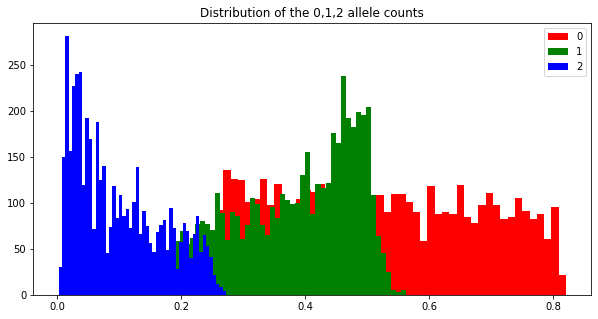

In [290]:
# Load data in int8 format and look at the non-standardized distribution of the features:
int8_sda = srd.read(dtype='int8', _require_float32_64=False)

# This gives a bit of perspective on the 0,1,2 prevalencies in the real data:
plt.hist(np.mean(int8_sda.val==0, axis=0),bins=50,color='r');
plt.hist(np.mean(int8_sda.val==1, axis=0),bins=50,color='g');
plt.hist(np.mean(int8_sda.val==2, axis=0),bins=50,color='b');
plt.legend(labels=['0','1','2']); plt.title('Distribution of the 0,1,2 allele counts'); plt.show()

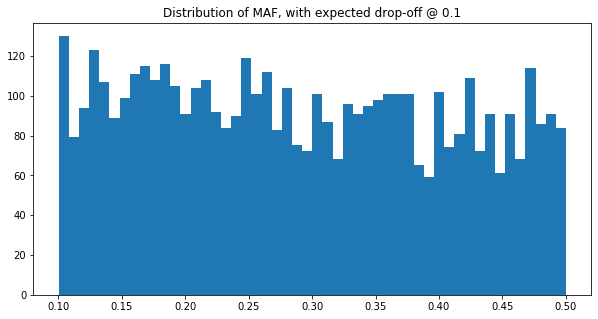

In [291]:
assert (int8_sda.val.min() == 0) and (int8_sda.val.max() == 2)
plt.hist(int8_sda.val.sum(axis=0)/(2*int8_sda.shape[0]), bins=50); plt.title('Distribution of MAF, with expected drop-off @ 0.1'); 

In [282]:
# psrc(implot)

# Appendix

In [ ]:
# # Under dev:
# ## PRS-CS
# np.random.seed(random_state+3)
# w = np.random.randn(n_snps)*np.sqrt(h2/n_snps)
# effects_df['ridge'] = w
# Xw = X.dot(w)
# e  = np.random.randn(n_samps)*np.sqrt(1-h2)
# y  = Xw + e
# pheno_df['ridge'] = y
# print(Xw.var())
# print(y.std())

In [ ]:
# # Generation of a Phenotype object, this saves to disk nicely:
# # Dont be confused by the fact that it is a SnpData object, there is no SNP data in it. (we are working with labels y now and not with X=genetics)
# dt = dict(header=pheno_df.columns,vals=pheno_df.values,iid=pheno_df.index.to_frame().values)
# dt['iid'] = np.array(dt['iid'], dtype=str)
# sim_prd =  Pheno(dt)
# sim_pda =  sim_prd.read()
# # print('Have a look at the output of sim_pda, to check:')
# # sim_pda

In [ ]:
# # Creating trn, val & tst splits:
# np.random.seed(random_state+12)
# # Since all samples are generated randomly no shuffling needed:
# all_idx = np.arange(len(sim_sda.iid))[:(n_trn+n_val+n_tst)] 
# trn_idx = all_idx[:n_trn];                        trn_iids = sim_sda.iid[trn_idx]
# val_idx = all_idx[n_trn:n_trn+n_val];             val_iids = sim_sda.iid[val_idx]
# tst_idx = all_idx[n_trn+n_val:n_trn+n_val+n_tst]; tst_iids = sim_sda.iid[tst_idx]

In [292]:
# # Write all simulated data to ./data/
# idx_dt = dict(train=trn_iids, valid=val_iids, test=tst_iids)
# for pheno_name in pheno_df.columns:
#     for key, cur_iids in idx_dt.items():
#         cur_prd = sim_prd[:,sim_prd.sid_to_index([pheno_name])]
#         cur_pda = cur_prd[cur_prd.iid_to_index(cur_iids),:].read()
#         fn = base_fn + f'{pheno_name}.{key}'
#         print(f'saving: {fn}')
#         Pheno.write(fn, cur_pda)

In [50]:
# pearsonr(Xw,y)[0]**2
# np.unique(pheno_df.index.get_level_values('FID')).shape
# (effects_df['spike_slab']!=0).sum()
# np.unique(pheno_df.index.get_level_values('FID')).shape